# Clean the dataset

The goal is to:
1) Gather all the files in 1 folder images and 1 labels, no more train-valid-test set, as Roboflow does not allow to do that
2) Create groups of identical images (or very ressembling)

## 1. Fusion

In [1]:
import os
import shutil
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torchvision import models, transforms

from sklearn.cluster import KMeans
from transformers import CLIPProcessor, CLIPModel
import hdbscan
print(torch.__version__)  # doit afficher 2.6.0 ou plus
# 🔧 Nom du dataset à nettoyer


/Users/benjaminmallefait/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.7.1


In [4]:
dataset_name = "png-mask-semantic"
# Chemins
source_path = os.path.join("datasets", dataset_name)
target_path = os.path.join("datasets_clean", dataset_name)
# Créer le dossier de destination et ses sous-dossiers
merged_images_dir = os.path.join(target_path, "images")
merged_labels_dir = os.path.join(target_path, "labels")
os.makedirs(merged_images_dir, exist_ok=True)
os.makedirs(merged_labels_dir, exist_ok=True)
# Copier les images et labels depuis train/valid/test
for split in ["train", "valid", "test"]:
    split_images = os.path.join(source_path, split)
    print(f"Looking in: {split_images} → Exists? {os.path.exists(split_images)}")
    split_labels = os.path.join(source_path, split, "labels")
    if os.path.exists(split_images):
        for fname in os.listdir(split_images):
            shutil.copy2(os.path.join(split_images, fname), os.path.join(merged_images_dir, fname))
    if os.path.exists(split_labels):
        for fname in os.listdir(split_labels):
            shutil.copy2(os.path.join(split_labels, fname), os.path.join(merged_labels_dir, fname))
print("✅ Fusion propre dans datasets_clean terminée.")

Looking in: datasets/png-mask-semantic/train → Exists? True
Looking in: datasets/png-mask-semantic/valid → Exists? True
Looking in: datasets/png-mask-semantic/test → Exists? True
✅ Fusion propre dans datasets_clean terminée.


In [2]:

# Racine des datasets
root_source = "datasets_bis"
root_target = "datasets_clean"

# Création de la racine de sortie si elle n'existe pas
os.makedirs(root_target, exist_ok=True)

# Parcourir tous les datasets dans 'datasets/'
for dataset_name in os.listdir(root_source):
    source_path = os.path.join(root_source, dataset_name)
    target_path = os.path.join(root_target, dataset_name)

    if not os.path.isdir(source_path):
        continue  # On ignore les fichiers

    # Dossiers cibles
    merged_images_dir = os.path.join(target_path, "images")
    merged_labels_dir = os.path.join(target_path, "labels")

    # Skip si déjà nettoyé (présence des dossiers images + labels)
    if os.path.exists(merged_images_dir) and os.path.exists(merged_labels_dir):
        print(f"✅ Déjà nettoyé : {dataset_name} → on ignore.")
        continue

    # Sinon, créer les dossiers cibles
    os.makedirs(merged_images_dir, exist_ok=True)
    os.makedirs(merged_labels_dir, exist_ok=True)

    # Copie les images et labels de train/valid/test (si présents)
    for split in ["train", "valid", "test"]:
        split_images = os.path.join(source_path, split, "images")
        split_labels = os.path.join(source_path, split, "labels")

        if os.path.exists(split_images):
            for fname in os.listdir(split_images):
                shutil.copy2(os.path.join(split_images, fname), os.path.join(merged_images_dir, fname))

        if os.path.exists(split_labels):
            for fname in os.listdir(split_labels):
                shutil.copy2(os.path.join(split_labels, fname), os.path.join(merged_labels_dir, fname))

    print(f"🧼 Dataset traité : {dataset_name}")

🧼 Dataset traité : asd
🧼 Dataset traité : Li-Battery DM Code Detection
🧼 Dataset traité : dm-milk-v4
🧼 Dataset traité : 2D_DETECTION
🧼 Dataset traité : 2d_data_code_detect
🧼 Dataset traité : Detector
🧼 Dataset traité : DM_Code_DataSet
🧼 Dataset traité : OR Code Detection
🧼 Dataset traité : 2dDataMatrix
🧼 Dataset traité : icecream 2


## 2. Group ressembling images

In [4]:
# ⚙️ Dossier contenant les images fusionnées
input_folder = merged_images_dir

# 📤 Dossier de sortie pour les groupes d’images similaires
output_base = os.path.join(target_path, "grouped_images")
os.makedirs(output_base, exist_ok=True)

In [5]:
# Chargement du modèle ResNet18 pré-entraîné
model = models.resnet18(pretrained=True)
model = model.eval()

# Prétraitement des images (224x224 comme attendu par ResNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

/Users/benjaminmallefait/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/benjaminmallefait/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
image_paths = [os.path.join(input_folder, f) for f in os.listdir(input_folder) 
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

features = []
filenames = []

for path in tqdm(image_paths, desc="Extracting features"):
    try:
        img = Image.open(path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0)
        with torch.no_grad():
            embedding = model(img_tensor).squeeze().numpy()
        features.append(embedding)
        filenames.append(os.path.basename(path))
    except Exception as e:
        print(f"⚠️ Skipped {path}: {e}")

features = np.array(features).astype("float32")

Extracting features: 100%|██████████| 40384/40384 [21:42<00:00, 31.01it/s]


In [7]:
from sklearn.preprocessing import StandardScaler

# Normaliser les features (recommandé pour HDBSCAN)
scaled_features = StandardScaler().fit_transform(features)

# Clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean')
labels = clusterer.fit_predict(scaled_features)

print(f"✅ Nombre de clusters détectés (hors bruit) : {len(set(labels)) - (1 if -1 in labels else 0)}")

✅ Nombre de clusters détectés (hors bruit) : 1843


In [8]:
for label, filename in zip(labels, filenames):
    cluster_dir = os.path.join(output_base, f"cluster_{label}")
    os.makedirs(cluster_dir, exist_ok=True)
    
    src_path = os.path.join(input_folder, filename)
    dst_path = os.path.join(cluster_dir, filename)
    
    shutil.copy2(src_path, dst_path)

---

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
output_base = f"datasets_clean_clip/{dataset_name}/grouped_images"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
image_paths = [os.path.join(input_folder, f) for f in os.listdir(input_folder)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

features = []
filenames = []

for path in tqdm(image_paths, desc="Extracting CLIP features"):
    try:
        image = Image.open(path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
        embedding = outputs.squeeze().cpu().numpy()
        features.append(embedding)
        filenames.append(os.path.basename(path))
    except Exception as e:
        print(f"❌ Error on {path}: {e}")

features = np.array(features)

Extracting CLIP features: 100%|██████████| 5411/5411 [06:58<00:00, 12.94it/s]


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normaliser les features
scaled_features = StandardScaler().fit_transform(features)

# Appliquer HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='euclidean')
labels = clusterer.fit_predict(scaled_features)

print(f"✅ Nombre de clusters trouvés (hors bruit) : {len(set(labels)) - (1 if -1 in labels else 0)}")

✅ Nombre de clusters trouvés (hors bruit) : 837


In [ ]:
for label, filename in zip(labels, filenames):
    cluster_dir = os.path.join(output_base, f"cluster_{label}")
    os.makedirs(cluster_dir, exist_ok=True)

    src = os.path.join(input_folder, filename)
    dst = os.path.join(cluster_dir, filename)
    shutil.copy2(src, dst)

## Choose which images to keep

In [1]:
import os
import shutil
from IPython.display import display, clear_output
import ipywidgets as widgets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

dataset_name = "dm-and-qr-detection-hke7e"

In [2]:
# À adapter selon ton dataset
base_dir = f"datasets_clean/{dataset_name}/grouped_images"
output_dir = f"datasets_clean/{dataset_name}/filtered_dataset"
os.makedirs(output_dir, exist_ok=True)
# Vider le dossier filtered_dataset au lancement (optionnel)
for f in os.listdir(output_dir):
    os.remove(os.path.join(output_dir, f))

cluster_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("cluster_")])
print(f"Nombre de clusters trouvés : {len(cluster_dirs)}")
# Fonction pour afficher les images d'un cluster
print(cluster_dirs)

# Limite d'images par page
PAGE_SIZE = 100

Nombre de clusters trouvés : 93
['cluster_-1', 'cluster_0', 'cluster_1', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_2', 'cluster_20', 'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27', 'cluster_28', 'cluster_29', 'cluster_3', 'cluster_30', 'cluster_31', 'cluster_32', 'cluster_33', 'cluster_34', 'cluster_35', 'cluster_36', 'cluster_37', 'cluster_38', 'cluster_39', 'cluster_4', 'cluster_40', 'cluster_41', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_46', 'cluster_47', 'cluster_48', 'cluster_49', 'cluster_5', 'cluster_50', 'cluster_51', 'cluster_52', 'cluster_53', 'cluster_54', 'cluster_55', 'cluster_56', 'cluster_57', 'cluster_58', 'cluster_59', 'cluster_6', 'cluster_60', 'cluster_61', 'cluster_62', 'cluster_63', 'cluster_64', 'cluster_65', 'cluster_66', 'cluster_67', 'cluster_68', 'cluster_69', 'cluster_7', 'cluster_

In [3]:
from collections import defaultdict
from matplotlib.patches import Rectangle

# Pour stocker la sélection globale cluster → liste d'images
selection_memory = defaultdict(set)

def show_cluster(cluster_idx, page_idx=0):
    clear_output(wait=True)
    cluster_name = cluster_dirs[cluster_idx]
    cluster_path = os.path.join(base_dir, cluster_name)
    all_images = sorted(os.listdir(cluster_path))
    
    total_pages = (len(all_images) + PAGE_SIZE - 1) // PAGE_SIZE
    page_start = page_idx * PAGE_SIZE
    page_end = min((page_idx + 1) * PAGE_SIZE, len(all_images))
    images = all_images[page_start:page_end]

    print(f"📂 Cluster {cluster_name} - Page {page_idx + 1}/{total_pages} ({len(images)} images affichées)")

    n_cols = min(5, len(images))
    n_rows = (len(images) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

    toggle_state = [img in selection_memory[cluster_name] for img in images]
    rect_patches = [None] * len(images)

    def draw_rectangle(ax):
        return ax.add_patch(Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                                      fill=False, edgecolor='green', linewidth=4))

    def on_click(event):
        for i, ax in enumerate(axes[:len(images)]):
            if ax == event.inaxes:
                toggle_state[i] = not toggle_state[i]
                img_name = images[i]
                if toggle_state[i]:
                    selection_memory[cluster_name].add(img_name)
                    rect_patches[i] = draw_rectangle(ax)
                else:
                    selection_memory[cluster_name].discard(img_name)
                    if rect_patches[i]:
                        rect_patches[i].remove()
                        rect_patches[i] = None
                fig.canvas.draw_idle()

    fig.canvas.mpl_connect("button_press_event", on_click)

    for i, (img_name, ax) in enumerate(zip(images, axes)):
        img = Image.open(os.path.join(cluster_path, img_name))
        ax.imshow(img)
        ax.axis("off")
        if toggle_state[i]:
            rect_patches[i] = draw_rectangle(ax)

    for j in range(len(images), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    # Widgets
    select_all = widgets.Button(description="✅ Tout sélectionner cette page")
    validate = widgets.Button(description="Ajouter sélectionnées")
    skip = widgets.Button(description="⏭️ Skip cluster")
    next_page = widgets.Button(description="➡️ Page suivante")
    prev_page = widgets.Button(description="⬅️ Page précédente")
    prev_cluster = widgets.Button(description="⬅️ Cluster précédent")

    def on_select_all(b):
        for i, ax in enumerate(axes[:len(images)]):
            if not toggle_state[i]:
                toggle_state[i] = True
                selection_memory[cluster_name].add(images[i])
                rect_patches[i] = draw_rectangle(ax)
        fig.canvas.draw_idle()

    def on_validate(b):
        for img_name in selection_memory[cluster_name]:
            src = os.path.join(cluster_path, img_name)
            dst = os.path.join(output_dir, img_name)
            shutil.copy2(src, dst)
        if cluster_idx + 1 < len(cluster_dirs):
            show_cluster(cluster_idx + 1, 0)
        else:
            print("✅ Tous les clusters ont été parcourus.")

    def on_skip(b):
        if cluster_idx + 1 < len(cluster_dirs):
            show_cluster(cluster_idx + 1, 0)
        else:
            print("✅ Tous les clusters ont été parcourus.")

    def on_prev_cluster(b):
        if cluster_idx > 0:
            show_cluster(cluster_idx - 1, 0)

    def on_next(b):
        if page_idx + 1 < total_pages:
            show_cluster(cluster_idx, page_idx + 1)

    def on_prev(b):
        if page_idx > 0:
            show_cluster(cluster_idx, page_idx - 1)

    select_all.on_click(on_select_all)
    validate.on_click(on_validate)
    skip.on_click(on_skip)
    next_page.on_click(on_next)
    prev_page.on_click(on_prev)
    prev_cluster.on_click(on_prev_cluster)

    controls = widgets.HBox([validate, skip, select_all, prev_page, next_page, prev_cluster])
    display(controls)

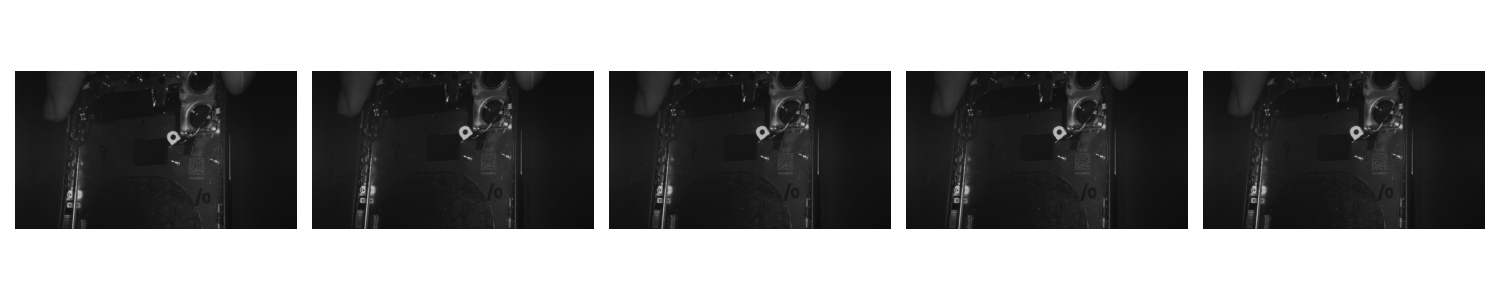

In [ ]:
show_cluster(0)

## Not forgeting the labels !

In [1]:
import os
import shutil

# Chemin vers le dossier contenant tous les datasets
base_dir = 'datasets_clean'

# Parcours de chaque sous-dossier du dataset
for dataset_name in os.listdir(base_dir):
    dataset_path = os.path.join(base_dir, dataset_name)
    filtered_path = os.path.join(dataset_path, 'filtered_dataset')
    labels_path = os.path.join(dataset_path, 'labels')
    
    if os.path.isdir(filtered_path) and os.path.isdir(labels_path):
        output_labels_path = os.path.join(dataset_path, 'filtered_dataset_labels')
        os.makedirs(output_labels_path, exist_ok=True)

        # Liste des fichiers image filtrés (sans l'extension pour correspondance)
        filtered_images = {
            os.path.splitext(f)[0] for f in os.listdir(filtered_path)
            if os.path.isfile(os.path.join(filtered_path, f))
        }

        # Copie des fichiers de labels correspondant
        for label_file in os.listdir(labels_path):
            label_name = os.path.splitext(label_file)[0]
            if label_name in filtered_images:
                src = os.path.join(labels_path, label_file)
                dst = os.path.join(output_labels_path, label_file)
                shutil.copyfile(src, dst)

        print(f"→ Labels copiés pour : {dataset_name}")
    else:
        print(f"⤬ Pas de 'filtered_dataset' ou de 'labels' dans : {dataset_name}")

→ Labels copiés pour : real_2dcodes-xct7b
⤬ Pas de 'filtered_dataset' ou de 'labels' dans : datamatrixfit-qowrb
→ Labels copiés pour : dmcode-z0knd
→ Labels copiés pour : dm-and-qr-detection-hke7e
→ Labels copiés pour : 20240517-bhpps
⤬ Pas de 'filtered_dataset' ou de 'labels' dans : implementacao-gezj2
→ Labels copiés pour : recntagledmtest-ovcjh
→ Labels copiés pour : datamatrix_140-xw1je
⤬ Pas de 'filtered_dataset' ou de 'labels' dans : pcb_dataset-eislu-g6ps2


## Keep only the picture with the good labels or delete useless labels

🔷 Annotation POLYGONE détectée.
🔁 Conversion polygon ➝ AABB :
  Original  : [0.12373749999999999, 0.1540402777777778, 0.8257569444444444, 0.1351013888888889, 0.8472222222222222, 0.8308083333333334, 0.1439388888888889, 0.8611111111111112]
  Converted : class 0 0.485480 0.498106 0.723485 0.726010


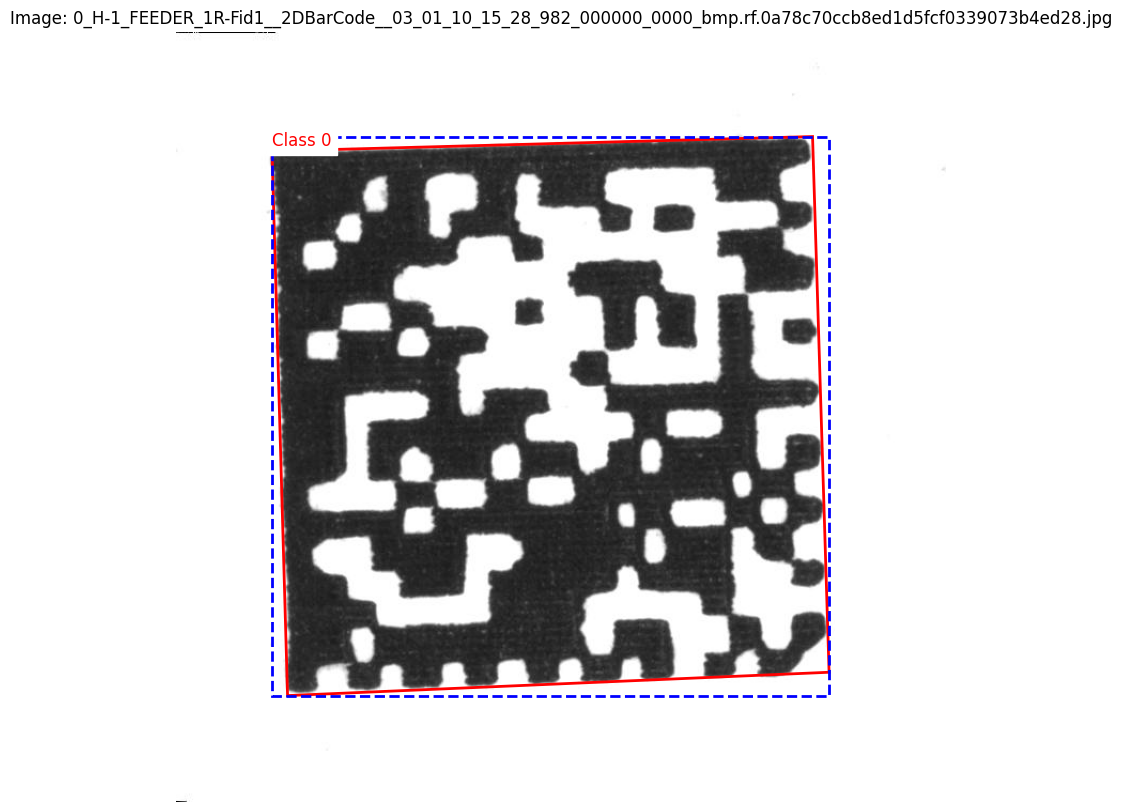

In [10]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# === Configuration ===
dataset_name = "Detector"
images_dir = os.path.join("datasets_clean", dataset_name, "images")
labels_dir = os.path.join("datasets_clean", dataset_name, "labels")

# Liste des fichiers image disponibles
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
if not image_files:
    print("⚠️ Aucun fichier image trouvé.")
else:
    # Choisir une image au hasard
    random_image = random.choice(image_files)
    image_path = os.path.join(images_dir, random_image)
    label_path = os.path.join(labels_dir, os.path.splitext(random_image)[0] + ".txt")

    # Ouvrir l'image
    image = Image.open(image_path)
    w, h = image.size

    # Préparer la figure
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    ax.set_title(f"Image: {random_image}")

    # Lire et tracer les annotations (YOLO format)
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                
                if len(parts) == 5:
                    # Standard YOLO AABB
                    print("🟩 Annotation AABB détectée.")
                    x_center, y_center, box_width, box_height = map(float, parts[1:])
                    x = (x_center - box_width / 2) * w
                    y = (y_center - box_height / 2) * h
                    bw = box_width * w
                    bh = box_height * h

                    rect = patches.Rectangle((x, y), bw, bh, linewidth=2, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x, y - 5, f"Class {class_id}", color='yellow', fontsize=12, backgroundcolor="black")

                elif len(parts) == 9:
                    # Polygon (4 points)
                    print("🔷 Annotation POLYGONE détectée.")
                    points = list(map(float, parts[1:]))
                    xs = points[0::2]
                    ys = points[1::2]

                    # Tracer le polygone original
                    polygon_points = [(x * w, y * h) for x, y in zip(xs, ys)]
                    poly_patch = patches.Polygon(polygon_points, closed=True, edgecolor='red', linewidth=2, fill=False)
                    ax.add_patch(poly_patch)
                    ax.text(polygon_points[0][0], polygon_points[0][1] - 5, f"Class {class_id}", color='red', fontsize=12, backgroundcolor="white")

                    # Conversion vers AABB
                    min_x = min(xs)
                    min_y = min(ys)
                    max_x = max(xs)
                    max_y = max(ys)

                    # Format YOLO : x_center, y_center, w, h
                    x_center = (min_x + max_x) / 2
                    y_center = (min_y + max_y) / 2
                    box_width = max_x - min_x
                    box_height = max_y - min_y

                    print(f"🔁 Conversion polygon ➝ AABB :")
                    print(f"  Original  : {points}")
                    print(f"  Converted : class {class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

                    # Afficher AABB convertie (en bleu)
                    x = (x_center - box_width / 2) * w
                    y = (y_center - box_height / 2) * h
                    bw = box_width * w
                    bh = box_height * h
                    rect = patches.Rectangle((x, y), bw, bh, linewidth=2, edgecolor='blue', linestyle='--', facecolor='none')
                    ax.add_patch(rect)

                else:
                    print(f"⚠️ Format d’annotation inconnu ou non supporté : {line.strip()}")

    else:
        print(f"⚠️ Aucun label trouvé pour {random_image}")

    plt.axis('off')
    plt.show()

## Filtrer les labels à retenir


In [11]:
import os
import shutil

# === CONFIGURATION ===
input_images_dir = os.path.join('datasets_clean', dataset_name, 'images')
input_labels_dir = os.path.join('datasets_clean', dataset_name, 'labels')

output_images_dir = os.path.join('datasets_clean', dataset_name,'filtered_dataset')
output_labels_dir = os.path.join('datasets_clean', dataset_name,'filtered_dataset_labels')

# Label à filtrer (ex: barcode est classe '0')
class_ids_to_remove = {'0', '1'}  # <-- les ID des classes à supprimer (ex: barcode, datamatrix, etc.)

# Créer les dossiers de sortie
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# === TRAITEMENT DES LABELS ===
for filename in os.listdir(input_labels_dir):
    if not filename.endswith('.txt'):
        continue

    label_path = os.path.join(input_labels_dir, filename)
    with open(label_path, 'r') as f:
        lines = f.readlines()

    to_remove = [line for line in lines if line.strip().split()[0] in class_ids_to_remove]
    other_lines = [line for line in lines if line.strip().split()[0] not in class_ids_to_remove]

    # Cas 1 : uniquement des barcodes → ignorer l'image
    if to_remove and not other_lines:
        labels_in_image = sorted(set(line.strip().split()[0] for line in lines))
        print(f"🗑️ Image ignorée : {filename} — labels présents : {labels_in_image}")
        continue

    # Cas 2 : barcodes + autres → on retire uniquement les barcodes
    filtered_lines = other_lines if to_remove else lines

    # Sauvegarde du fichier label filtré
    output_label_path = os.path.join(output_labels_dir, filename)
    with open(output_label_path, 'w') as f_out:
        f_out.writelines(filtered_lines)

    # Copier l’image associée si le label est conservé
    basename = os.path.splitext(filename)[0]
    for ext in ['.jpg', '.jpeg', '.png']:
        img_path = os.path.join(input_images_dir, basename + ext)
        if os.path.exists(img_path):
            shutil.copy2(img_path, os.path.join(output_images_dir, basename + ext))
            break  # On ne copie qu’une seule fois l’image

print(f"Taille origniale : {len(os.listdir(input_images_dir))} images, {len(os.listdir(input_labels_dir))} labels")
print(f"✅ Traitement terminé pour {dataset_name} : {len(os.listdir(output_images_dir))} images et {len(os.listdir(output_labels_dir))} labels filtrés.")

🗑️ Image ignorée : 66816_H-1_FEEDER_1F-Fid2__Fiducial__09_07_09_51_10_008_000_ae05-1_bmp.rf.db0eef4a539df241336534c2ea9fba29.txt — labels présents : ['0']
🗑️ Image ignorée : 0_H-1_FEEDER_1F-Fid1__2DBarCode__01_29_13_51_55_297_000000_0000_bmp.rf.c410661a48a95289ca48acf4db4d5db3.txt — labels présents : ['0']
🗑️ Image ignorée : 0_H-1_FEEDER_Bitmap__2DBarCode__03_12_05_50_38_670_000000_ffff_bmp.rf.6b8d7678fc086ca983ec97a8d37103c4.txt — labels présents : ['0']
🗑️ Image ignorée : 0_H-1_FEEDER_1F-Fid1__2DBarCode__03_01_14_04_07_270_000000_0000_bmp.rf.05525a6e5a403ce13db3ea98689857c1.txt — labels présents : ['0']
🗑️ Image ignorée : nozzle1-2Dbarcode_bmp.rf.c215a06fb9cd48b1361657c614623b65.txt — labels présents : ['0']
🗑️ Image ignorée : 0_H-1_FEEDER_1R-Fid1__2DBarCode__02_23_19_25_58_861_000000_0000_bmp.rf.c251a356c7a894a3bcc986951f92b3fe.txt — labels présents : ['0']
🗑️ Image ignorée : 0_H-1_FEEDER_Bitmap__2DBarCode__02_25_20_27_31_248_000000_0000_bmp.rf.c3003fbe0f82eda06be7e0fed2f9a51b.txt —

## Convertir en grayscale chaque image de filtred_dataset s'il existe,  ou de images sinon

In [18]:
import os
from PIL import Image

# Dossier principal contenant tous les datasets
base_dir = "datasets_clean"
to_convert = "Detector"

# Parcourir chaque sous-dossier (dataset)
for dataset in os.listdir(base_dir):
    # if dataset != to_convert:
    #     continue  # On ne traite que le dataset spécifié
    dataset_path = os.path.join(base_dir, dataset)
    if not os.path.isdir(dataset_path):
        continue  # On ignore les fichiers

    # Déterminer le dossier d'entrée : 'filtered_dataset' ou 'images'
    input_dir = None
    for candidate in ['filtered_dataset', 'images']:
        test_path = os.path.join(dataset_path, candidate)
        if os.path.exists(test_path):
            input_dir = test_path
            break

    if input_dir is None:
        print(f"⏭️ Aucun dossier d'image trouvé pour {dataset}")
        continue

    # Créer le dossier de sortie : 'grayscale_dataset'
    output_dir = os.path.join(dataset_path, 'grayscale_dataset')
    os.makedirs(output_dir, exist_ok=True)

    print(f"🎨 Conversion en niveaux de gris : {dataset} → {os.path.basename(input_dir)}")

    # Convertir chaque image en niveaux de gris et sauvegarder
    for img_file in os.listdir(input_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            input_img_path = os.path.join(input_dir, img_file)
            output_img_path = os.path.join(output_dir, img_file)

            try:
                img = Image.open(input_img_path).convert("L")  # 'L' = grayscale
                img.save(output_img_path)
            except Exception as e:
                print(f"⚠️ Erreur pour {input_img_path} : {e}")

🎨 Conversion en niveaux de gris : real_2dcodes-xct7b → filtered_dataset
🎨 Conversion en niveaux de gris : datamatrixfit-qowrb → images
🎨 Conversion en niveaux de gris : dpm-codes-xscfk → images
🎨 Conversion en niveaux de gris : dmcode-z0knd → filtered_dataset
🎨 Conversion en niveaux de gris : asd → images
🎨 Conversion en niveaux de gris : png-mask-semantic → images
🎨 Conversion en niveaux de gris : dmc-oriented-boxes-val-mmk2w → images
🎨 Conversion en niveaux de gris : Li-Battery DM Code Detection → images
🎨 Conversion en niveaux de gris : dm-and-qr-detection-hke7e → filtered_dataset
🎨 Conversion en niveaux de gris : dm-milk-v4 → images
🎨 Conversion en niveaux de gris : qrcut-zy7ed → images
🎨 Conversion en niveaux de gris : 2D_DETECTION → images
🎨 Conversion en niveaux de gris : 20240517-bhpps → filtered_dataset
🎨 Conversion en niveaux de gris : datamatrixmerged → images
🎨 Conversion en niveaux de gris : version2-0opxu-b3qwo → filtered_dataset
🎨 Conversion en niveaux de gris : 2d_data_

## Gris ✅ - Labels Filtrés ✅ --> Unifromiser les labels "0" "1" "2" ET Convertir polygon box en bounding box


📁 Dataset: real_2dcodes-xct7b | Labels trouvés: ['0', '1']
💡 Remapping suggéré (à modifier si besoin) :
"real_2dcodes-xct7b": {'0': '0', '1': '1'},


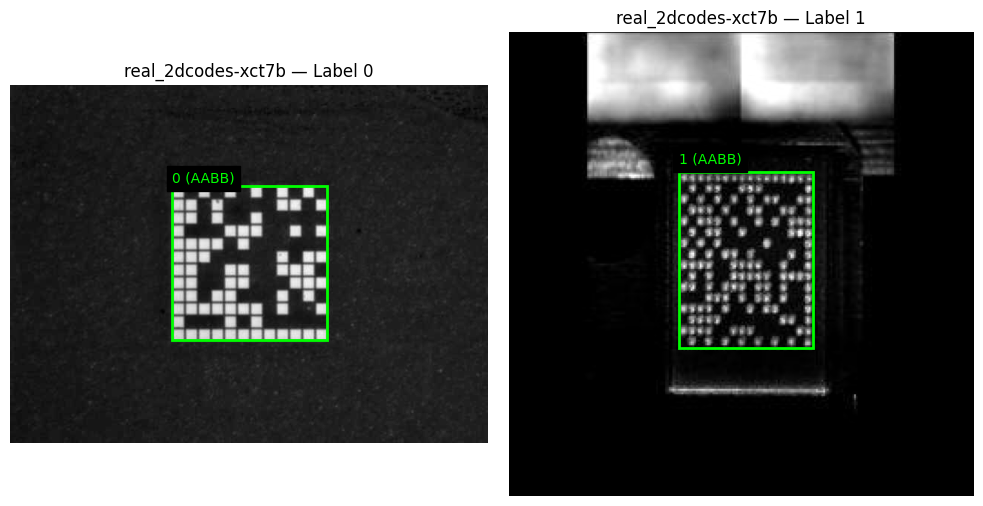


📁 Dataset: datamatrixfit-qowrb | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"datamatrixfit-qowrb": {'0': '0'},


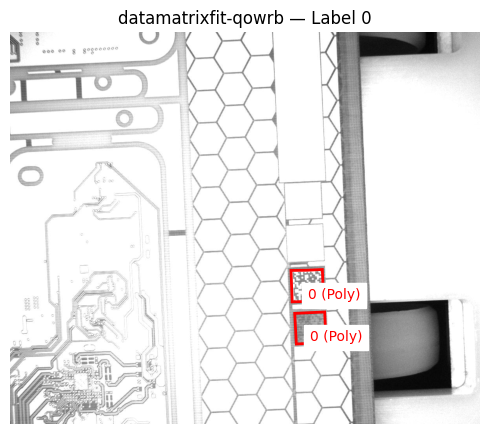


📁 Dataset: dpm-codes-xscfk | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"dpm-codes-xscfk": {'0': '0'},


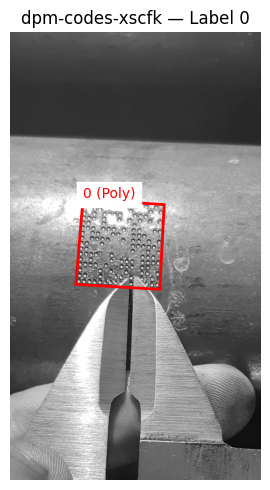


📁 Dataset: dmcode-z0knd | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"dmcode-z0knd": {'0': '0'},


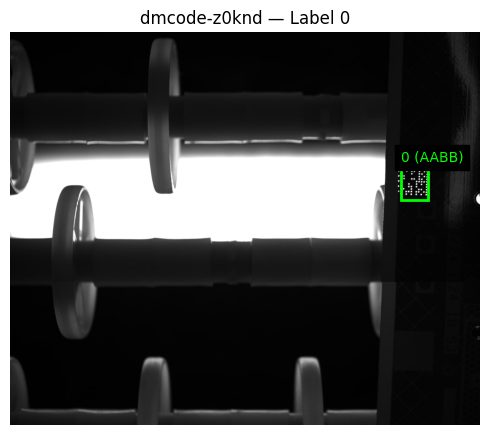


📁 Dataset: asd | Labels trouvés: ['0', '1']
💡 Remapping suggéré (à modifier si besoin) :
"asd": {'0': '0', '1': '1'},


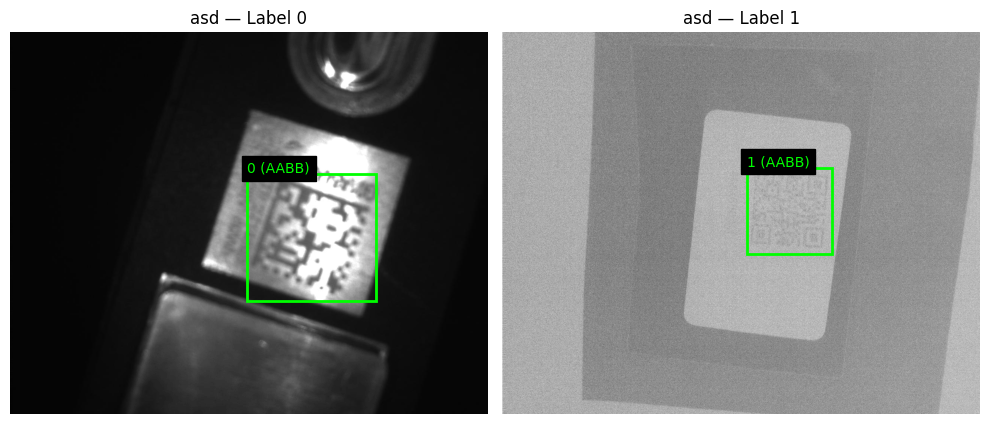


📁 Dataset: dmc-oriented-boxes-val-mmk2w | Labels trouvés: ['0', '1']
💡 Remapping suggéré (à modifier si besoin) :
"dmc-oriented-boxes-val-mmk2w": {'0': '0', '1': '1'},


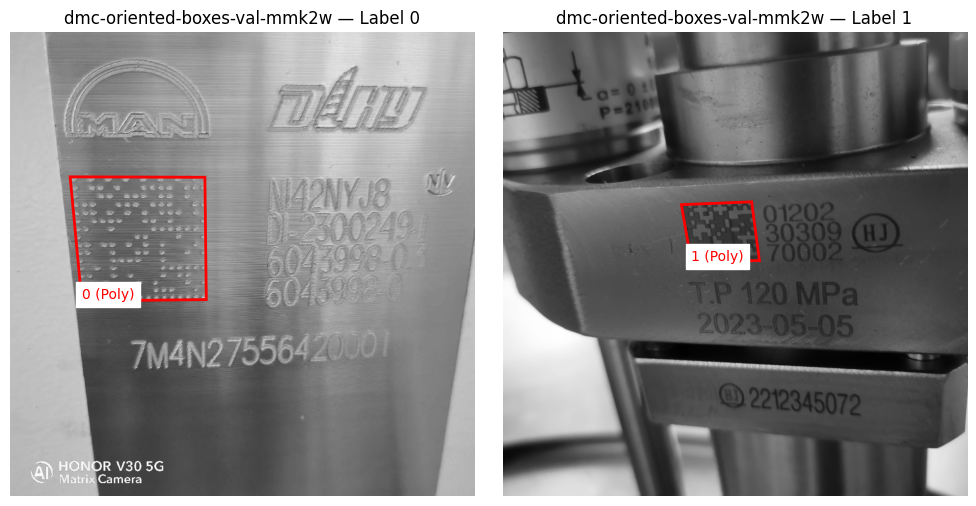


📁 Dataset: Li-Battery DM Code Detection | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"Li-Battery DM Code Detection": {'0': '0'},


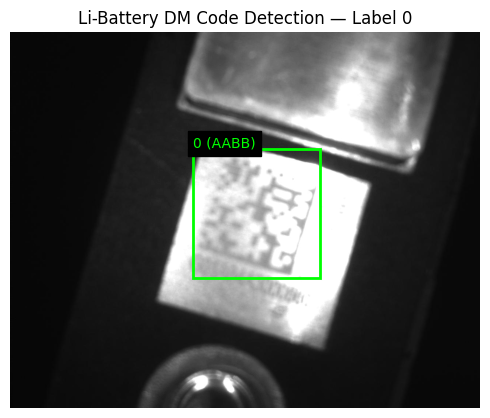


📁 Dataset: dm-and-qr-detection-hke7e | Labels trouvés: ['0', '1']
💡 Remapping suggéré (à modifier si besoin) :
"dm-and-qr-detection-hke7e": {'0': '0', '1': '1'},


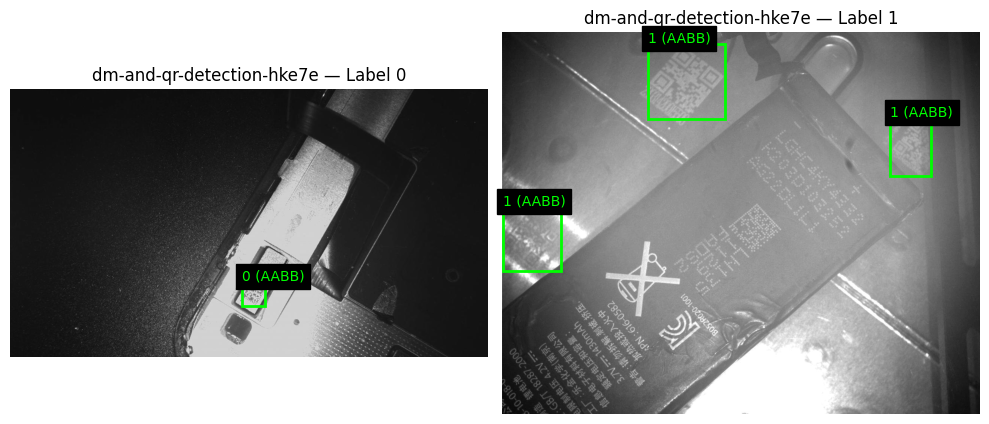


📁 Dataset: dm-milk-v4 | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"dm-milk-v4": {'0': '0'},


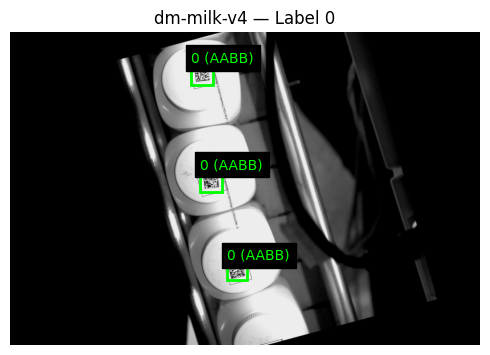


📁 Dataset: qrcut-zy7ed | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"qrcut-zy7ed": {'0': '0'},


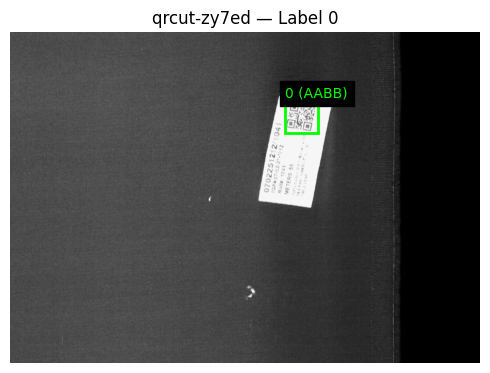


📁 Dataset: 2D_DETECTION | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"2D_DETECTION": {'0': '0'},


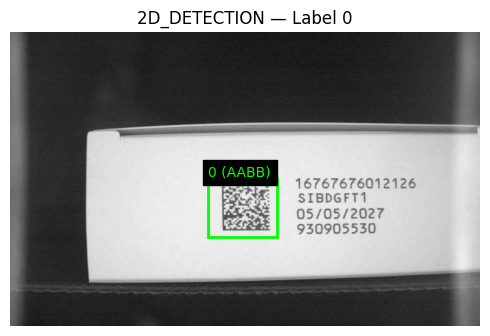


📁 Dataset: 20240517-bhpps | Labels trouvés: ['2', '1', '3', '0']
💡 Remapping suggéré (à modifier si besoin) :
"20240517-bhpps": {'2': '2', '1': '1', '3': '3', '0': '0'},


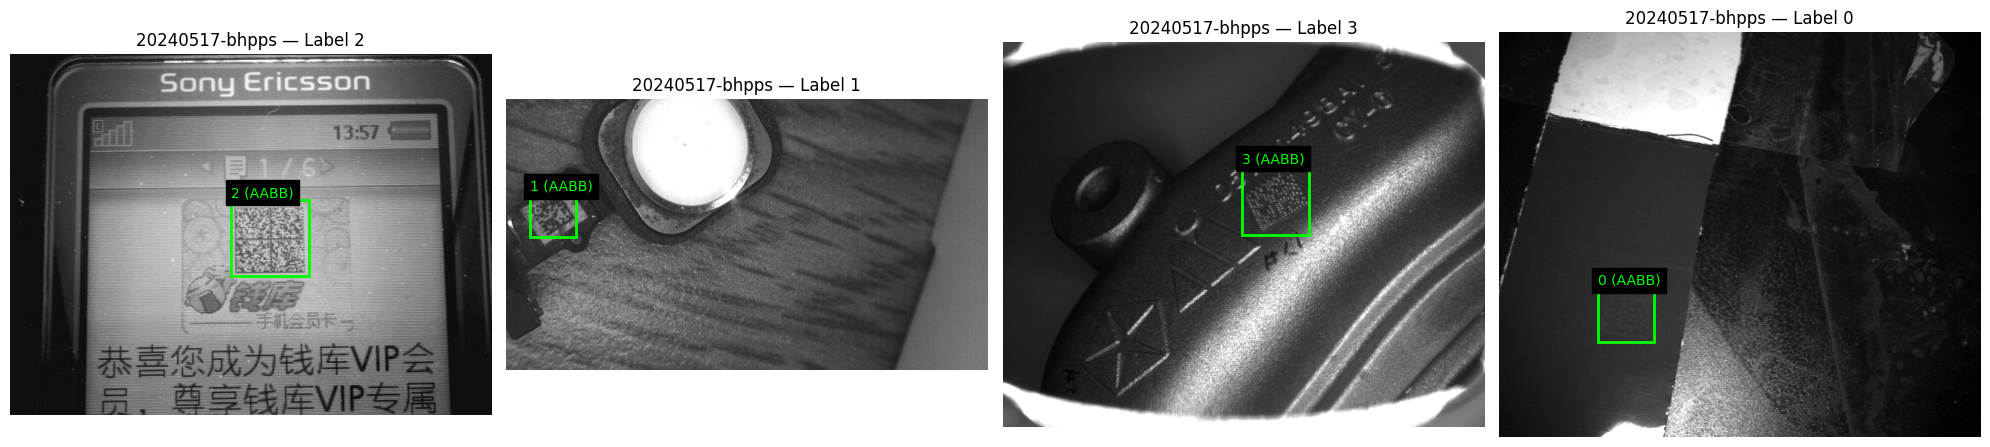


📁 Dataset: datamatrixmerged | Labels trouvés: ['1', '0']
💡 Remapping suggéré (à modifier si besoin) :
"datamatrixmerged": {'1': '1', '0': '0'},


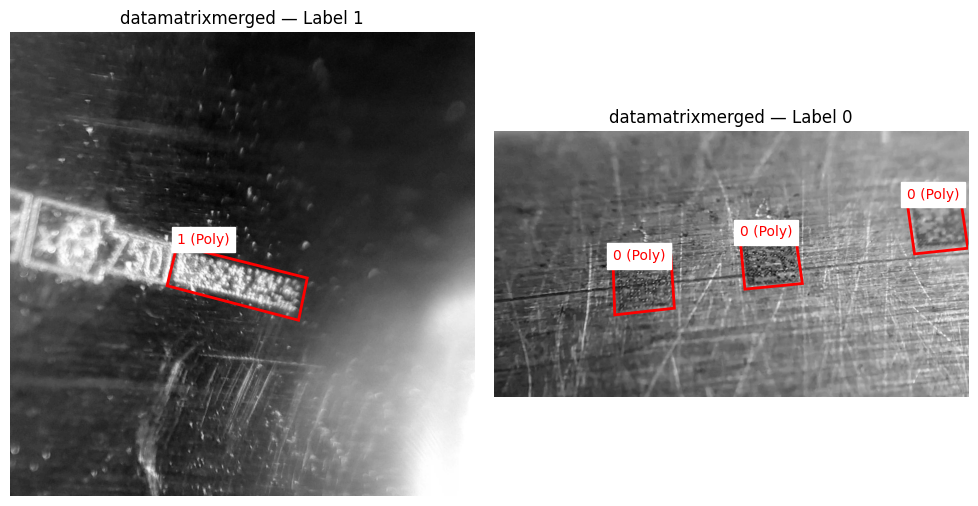


📁 Dataset: version2-0opxu-b3qwo | Labels trouvés: ['1', '2']
💡 Remapping suggéré (à modifier si besoin) :
"version2-0opxu-b3qwo": {'1': '1', '2': '2'},


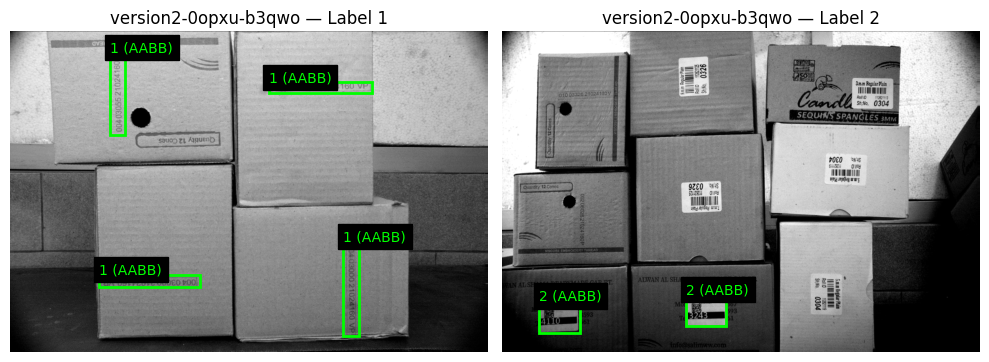


📁 Dataset: 2d_data_code_detect | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"2d_data_code_detect": {'0': '0'},


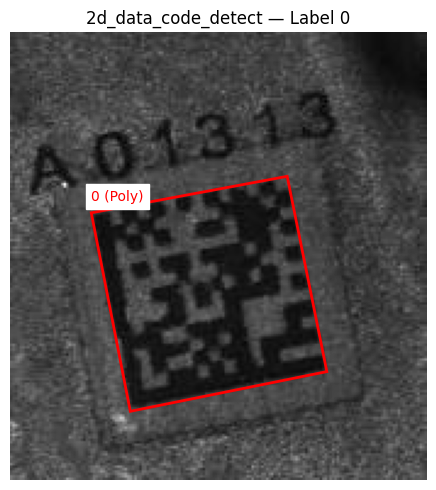


📁 Dataset: Detector | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"Detector": {'0': '0'},


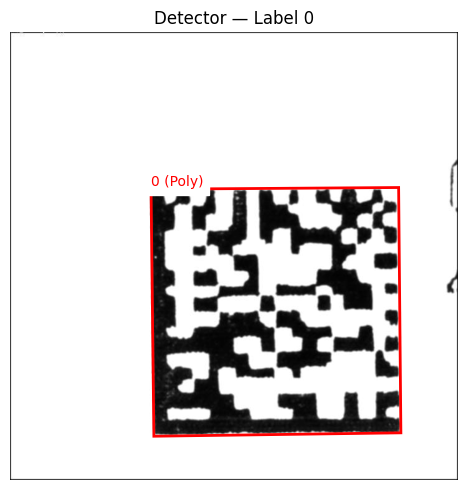


📁 Dataset: implementacao-gezj2 | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"implementacao-gezj2": {'0': '0'},


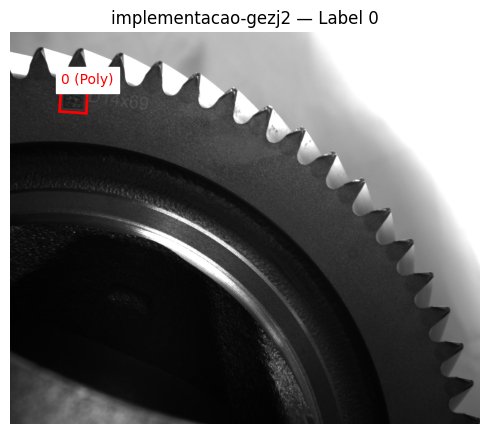


📁 Dataset: qrcodedetect-ovt2l | Labels trouvés: ['1']
💡 Remapping suggéré (à modifier si besoin) :
"qrcodedetect-ovt2l": {'1': '1'},


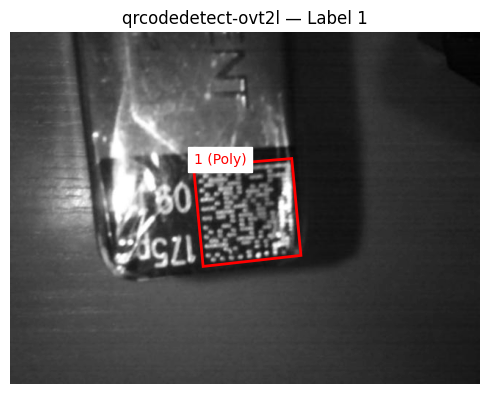


📁 Dataset: bcdmp-bnhpr | Labels trouvés: ['1']
💡 Remapping suggéré (à modifier si besoin) :
"bcdmp-bnhpr": {'1': '1'},


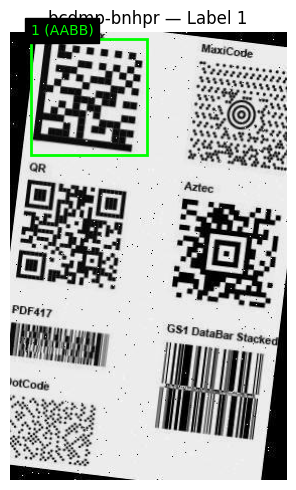


📁 Dataset: DM_Code_DataSet | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"DM_Code_DataSet": {'0': '0'},


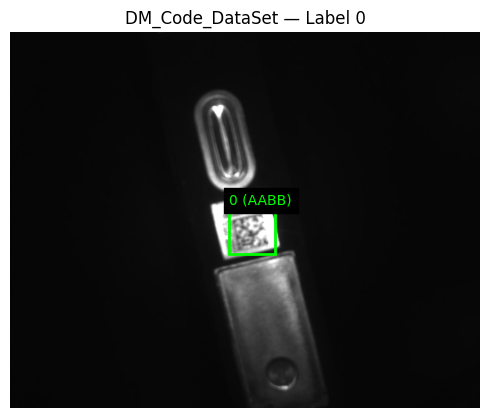


📁 Dataset: recntagledmtest-ovcjh | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"recntagledmtest-ovcjh": {'0': '0'},


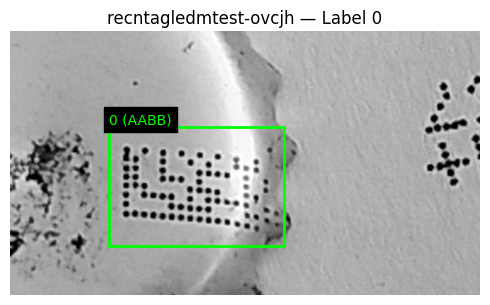


📁 Dataset: OR Code Detection | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"OR Code Detection": {'0': '0'},


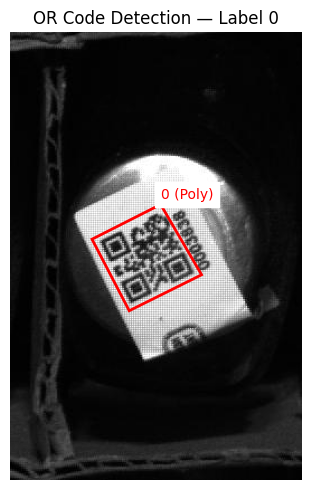


📁 Dataset: datamatrix_140-xw1je | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"datamatrix_140-xw1je": {'0': '0'},


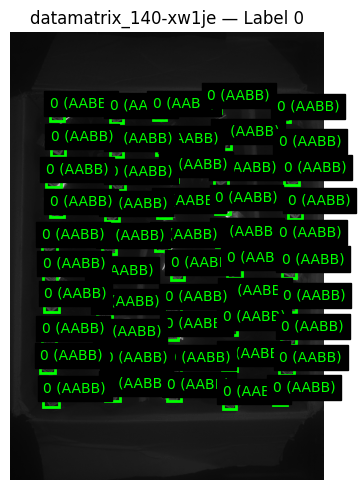


📁 Dataset: 2dDataMatrix | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"2dDataMatrix": {'0': '0'},


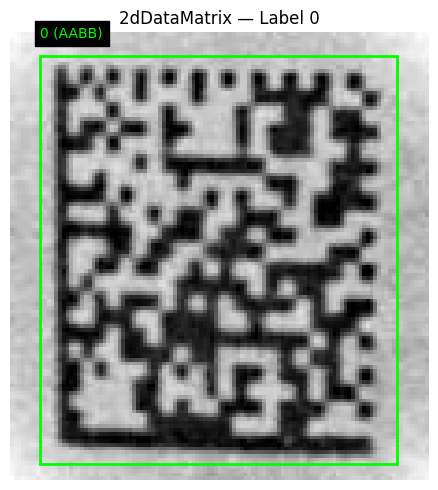


📁 Dataset: codes2024-jyoj6 | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"codes2024-jyoj6": {'0': '0'},


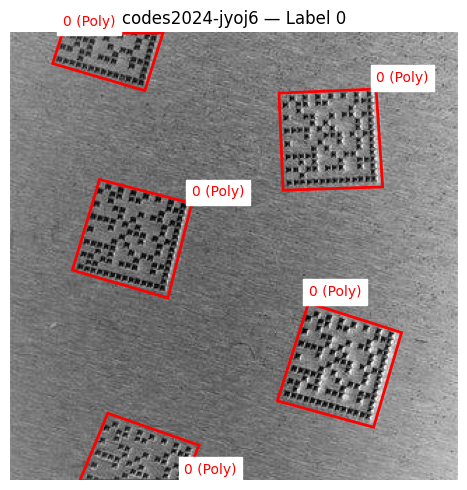


📁 Dataset: data-matrix-codes-jviot | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"data-matrix-codes-jviot": {'0': '0'},


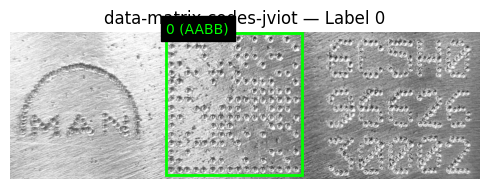


📁 Dataset: pcb_dataset-eislu-g6ps2 | Labels trouvés: ['0']
💡 Remapping suggéré (à modifier si besoin) :
"pcb_dataset-eislu-g6ps2": {'0': '0'},


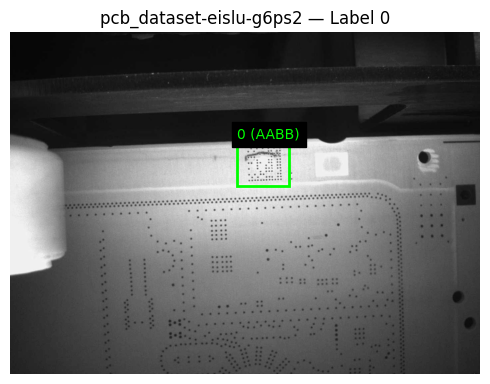


📁 Dataset: icecream 2 | Labels trouvés: ['0', '2', '1']
💡 Remapping suggéré (à modifier si besoin) :
"icecream 2": {'0': '0', '2': '2', '1': '1'},


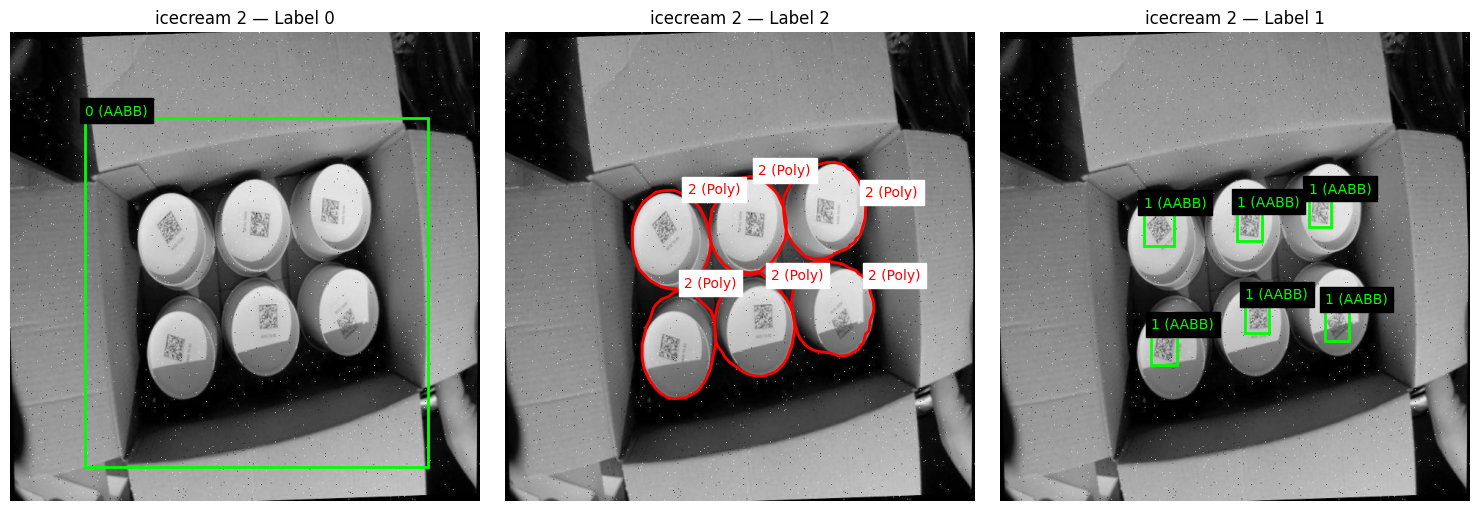

In [19]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# === CONFIGURATION ===
base_dir = "datasets_clean"

def read_labels(file_path):
    """Lit les annotations d'un fichier label"""
    labels = []
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            label = parts[0]
            if len(parts) % 2 == 1 and len(parts) >= 9:
                ann_type = "polygon"
            elif len(parts) == 5:
                ann_type = "bbox"
            else:
                ann_type = "unknown"
            coords = list(map(float, parts[1:]))
            labels.append((label, ann_type, coords))
    return labels

# Parcourir chaque dataset
for dataset in os.listdir(base_dir):
    dataset_path = os.path.join(base_dir, dataset)
    img_dir = os.path.join(dataset_path, "grayscale_dataset")
    if not os.path.isdir(img_dir):
        continue

    # Sélection du bon dossier de labels
    label_dir = os.path.join(dataset_path, "filtered_dataset_labels")
    if not os.path.exists(label_dir):
        label_dir = os.path.join(dataset_path, "labels")
    if not os.path.exists(label_dir):
        continue

    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        continue

    # Associer chaque label à une image aléatoire contenant ce label
    label_to_image = {}
    random.shuffle(image_files)

    for img_name in image_files:
        name_wo_ext = os.path.splitext(img_name)[0]
        label_path = os.path.join(label_dir, f"{name_wo_ext}.txt")
        if not os.path.exists(label_path):
            continue

        annotations = read_labels(label_path)
        for label, ann_type, coords in annotations:
            if label not in label_to_image:
                # Dès qu'on voit une image contenant ce label, on la garde
                label_to_image[label] = (img_name, [(label, ann_type, coords)])

        # Stop précoce si on a assez de labels
        if len(label_to_image) >= 5:
            break

    if not label_to_image:
        continue

    print(f"\n📁 Dataset: {dataset} | Labels trouvés: {list(label_to_image.keys())}")
    # Génère un bloc de code de remapping prêt à copier-coller
    remap_suggestion = {label: label for label in label_to_image.keys()}
    print("💡 Remapping suggéré (à modifier si besoin) :")
    print(f'"{dataset}": {remap_suggestion},')
    # Afficher en une seule ligne
    n = len(label_to_image)
    fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axs = [axs]

    for i, (label, (img_name, _)) in enumerate(label_to_image.items()):
        image_path = os.path.join(img_dir, img_name)
        image = Image.open(image_path)
        w, h = image.size

        ax = axs[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{dataset} — Label {label}")

        label_file = os.path.join(label_dir, f"{os.path.splitext(img_name)[0]}.txt")
        all_anns = read_labels(label_file)

        for l, ann_type, coords in all_anns:
            if l != label:
                continue

            if ann_type == "bbox":
                x_center, y_center, box_width, box_height = coords
                x = (x_center - box_width / 2) * w
                y = (y_center - box_height / 2) * h
                bw = box_width * w
                bh = box_height * h
                rect = patches.Rectangle((x, y), bw, bh, linewidth=2, edgecolor='lime', facecolor='none')
                ax.add_patch(rect)
                ax.text(x, y - 5, f"{l} (AABB)", color='lime', fontsize=10, backgroundcolor="black")

            elif ann_type == "polygon":
                xs = coords[0::2]
                ys = coords[1::2]
                polygon_points = [(x * w, y * h) for x, y in zip(xs, ys)]
                poly_patch = patches.Polygon(polygon_points, closed=True, edgecolor='red', linewidth=2, fill=False)
                ax.add_patch(poly_patch)
                ax.text(polygon_points[0][0], polygon_points[0][1] - 5, f"{l} (Poly)", color='red', fontsize=10, backgroundcolor="white")

            # break  # ✅ on ne garde qu'une annotation du label demandé

        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [20]:
import os

def remove_labels_from_dataset(dataset, labels_to_remove={'0', '2'}, base_dir="datasets_clean"):
    """
    Supprime les lignes contenant certains labels dans tous les fichiers de labels d'un dataset.
    Les fichiers modifiés sont enregistrés dans un dossier 'filtered_no_0_2_labels'.
    """
    dataset_path = os.path.join(base_dir, dataset)
    label_dir = os.path.join(dataset_path, "labels")
    if not os.path.exists(label_dir):
        print(f"⚠️ Dossier de labels introuvable pour {dataset}")
        return

    output_dir = os.path.join(dataset_path, "filtered_dataset_labels")
    os.makedirs(output_dir, exist_ok=True)

    for fname in os.listdir(label_dir):
        if not fname.endswith(".txt"):
            continue
        src = os.path.join(label_dir, fname)
        dst = os.path.join(output_dir, fname)
        with open(src, "r") as fin:
            lines = fin.readlines()
        filtered = [line for line in lines if line.strip() and line.strip().split()[0] not in labels_to_remove]
        with open(dst, "w") as fout:
            fout.writelines(filtered)
    print(f"✅ Fichiers filtrés enregistrés dans : {output_dir}")

# Exemple d'utilisation :
remove_labels_from_dataset("icecream 2")

✅ Fichiers filtrés enregistrés dans : datasets_clean/icecream 2/filtered_dataset_labels


In [21]:
import os

def remap_labels(label_mapping, base_dir="datasets_clean"):
    """
    Applique un remapping de labels dans chaque dataset spécifié
    et enregistre les nouveaux fichiers dans un dossier 'relabeled_labels'.
    
    label_mapping = {
        "dataset1": {"0": "1", "2": "1"},
        "dataset2": {"1": "0"}
    }
    """
    for dataset, mapping in label_mapping.items():
        dataset_path = os.path.join(base_dir, dataset)
        if not os.path.isdir(dataset_path):
            print(f"⚠️ Dataset {dataset} non trouvé.")
            continue

        # Choix du dossier de labels source
        source_dir = os.path.join(dataset_path, "filtered_dataset_labels")
        if not os.path.exists(source_dir):
            source_dir = os.path.join(dataset_path, "labels")
        if not os.path.exists(source_dir):
            print(f"⚠️ Aucun dossier de labels trouvé pour {dataset}.")
            continue

        # Dossier de sortie
        output_dir = os.path.join(dataset_path, "relabeled_labels")
        os.makedirs(output_dir, exist_ok=True)

        for file in os.listdir(source_dir):
            if not file.endswith(".txt"):
                continue
            input_path = os.path.join(source_dir, file)
            output_path = os.path.join(output_dir, file)

            with open(input_path, "r") as f:
                new_lines = []
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    original_label = parts[0]
                    new_label = mapping.get(original_label, original_label)  # garde l'original si pas dans le mapping
                    new_line = " ".join([new_label] + parts[1:])
                    new_lines.append(new_line)

            with open(output_path, "w") as out:
                out.write("\n".join(new_lines) + "\n")

        print(f"✅ Labels mis à jour pour {dataset} → {output_dir}")

In [22]:
# remap_labels({"real_2dcodes-xct7b": {'1': '0', '0': '0'}, 
#               "dmc-oriented-boxes-val-mmk2w": {'1': '0', '0': '0'}, 
#               "dm-and-qr-detection-hke7e": {'0': '0', '1': '0'}, 
#               "20240517-bhpps": {'2': '0', '3': '0', '0': '0', '1': '0'}, 
#               "datamatrixmerged": {'0': '0', '1': '0'}, 
#               "version2-0opxu-b3qwo": {'2': '0', '1': '0'}, 
#               "qrcodedetect-ovt2l": {'1': '0'}, 
#               "bcdmp-bnhpr": {'1': '0'}})

remap_labels({
    "icecream 2": {'1': '0'},
    "asd": {'0': '0', '1': '0'},
})

✅ Labels mis à jour pour icecream 2 → datasets_clean/icecream 2/relabeled_labels
✅ Labels mis à jour pour asd → datasets_clean/asd/relabeled_labels


In [23]:
def audit_relabeled_labels(base_dir="datasets_clean"):
    """
    Vérifie les labels présents dans chaque dataset après remapping.
    Affiche tous les labels restants dans le dossier 'relabeled_labels'.
    """
    print("🔍 Vérification des labels restants dans les dossiers 'relabeled_labels':\n")
    for dataset in os.listdir(base_dir):
        dataset_path = os.path.join(base_dir, dataset)
        label_dir = os.path.join(dataset_path, "relabeled_labels")
        if not os.path.exists(label_dir):
            label_dir = os.path.join(dataset_path, "filtered_dataset_labels")
        if not os.path.exists(label_dir):
            label_dir = os.path.join(dataset_path, "labels")
        if not os.path.exists(label_dir):
            print(f"⚠️ Aucun dossier de labels trouvé pour {dataset}.")
            continue

        found_labels = set()

        for file in os.listdir(label_dir):
            if not file.endswith(".txt"):
                continue
            with open(os.path.join(label_dir, file), "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        found_labels.add(parts[0])

        if found_labels:
            print(f"📁 {dataset} — Labels présents après remapping : {sorted(found_labels)}")
        else:
            print(f"📁 {dataset} — ⚠️ Aucun label trouvé dans relabeled_labels")
            
audit_relabeled_labels("datasets_clean") 

🔍 Vérification des labels restants dans les dossiers 'relabeled_labels':

📁 real_2dcodes-xct7b — Labels présents après remapping : ['0']
📁 datamatrixfit-qowrb — Labels présents après remapping : ['0']
📁 dpm-codes-xscfk — Labels présents après remapping : ['0']
📁 dmcode-z0knd — Labels présents après remapping : ['0']
📁 asd — Labels présents après remapping : ['0']
⚠️ Aucun dossier de labels trouvé pour .DS_Store.
📁 png-mask-semantic — ⚠️ Aucun label trouvé dans relabeled_labels
📁 dmc-oriented-boxes-val-mmk2w — Labels présents après remapping : ['0']
📁 Li-Battery DM Code Detection — Labels présents après remapping : ['0']
📁 dm-and-qr-detection-hke7e — Labels présents après remapping : ['0']
📁 dm-milk-v4 — Labels présents après remapping : ['0']
📁 qrcut-zy7ed — Labels présents après remapping : ['0']
📁 2D_DETECTION — Labels présents après remapping : ['0']
📁 20240517-bhpps — Labels présents après remapping : ['0']
📁 datamatrixmerged — Labels présents après remapping : ['0']
📁 version2-0op

In [26]:
def detect_polygon_datasets(base_dir="datasets_clean"):
    print("🔍 Datasets contenant des annotations polygonales :\n")
    for dataset in os.listdir(base_dir):
        dataset_path = os.path.join(base_dir, dataset)
        label_dir = os.path.join(dataset_path, "relabeled_labels")
        if not os.path.exists(label_dir):
            label_dir = os.path.join(dataset_path, "filtered_dataset_labels")
        if not os.path.exists(label_dir):
            label_dir = os.path.join(dataset_path, "labels")
        if not os.path.exists(label_dir) or not any(f.endswith(".txt") for f in os.listdir(label_dir)):
            print(f"⚠️ Aucun label trouvé pour {dataset}.")
            continue
        if not os.path.exists(label_dir):
            continue

        for file in os.listdir(label_dir):
            if not file.endswith(".txt"):
                continue
            with open(os.path.join(label_dir, file), "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 9 and len(parts) % 2 == 1:
                        print(f"✅ {dataset} contient au moins un polygon")
                        break
            break  # test rapide : 1 seul fichier suffit

In [27]:
detect_polygon_datasets("datasets_clean")

🔍 Datasets contenant des annotations polygonales :

✅ datamatrixfit-qowrb contient au moins un polygon
✅ dpm-codes-xscfk contient au moins un polygon
⚠️ Aucun label trouvé pour .DS_Store.
⚠️ Aucun label trouvé pour png-mask-semantic.
✅ dmc-oriented-boxes-val-mmk2w contient au moins un polygon
✅ datamatrixmerged contient au moins un polygon
✅ 2d_data_code_detect contient au moins un polygon
✅ Detector contient au moins un polygon
✅ implementacao-gezj2 contient au moins un polygon
✅ OR Code Detection contient au moins un polygon
✅ codes2024-jyoj6 contient au moins un polygon


In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
import shutil

def polygon_to_aabb(coords):
    xs = coords[0::2]
    ys = coords[1::2]
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min
    return [x_center, y_center, width, height]

def convert_polygons_to_bboxes(base_dir="datasets_clean", visualize=True, max_examples=2):
    for dataset in os.listdir(base_dir):
        dataset_path = os.path.join(base_dir, dataset)
        img_dir = os.path.join(dataset_path, "grayscale_dataset")
        if not os.path.isdir(img_dir):
            continue

        label_dir = os.path.join(dataset_path, "relabeled_labels")
        if not os.path.exists(label_dir):
            label_dir = os.path.join(dataset_path, "filtered_dataset_labels")
        if not os.path.exists(label_dir):
            label_dir = os.path.join(dataset_path, "labels")
        if not os.path.exists(label_dir) or not any(f.endswith(".txt") for f in os.listdir(label_dir)):
            print(f"⚠️ Aucun label trouvé pour {dataset}.")
            continue

        output_dir = os.path.join(dataset_path, "converted_labels")
        
        # Nettoyer le dossier s'il existe
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
        os.makedirs(output_dir)

        count = 0
        for label_file in os.listdir(label_dir):
            if not label_file.endswith(".txt"):
                continue

            input_path = os.path.join(label_dir, label_file)
            output_path = os.path.join(output_dir, label_file)
            image_file = os.path.splitext(label_file)[0] + ".png"
            image_path = os.path.join(img_dir, image_file)
            if not os.path.exists(image_path):
                image_file = os.path.splitext(label_file)[0] + ".jpg"
                image_path = os.path.join(img_dir, image_file)
                if not os.path.exists(image_path):
                    continue

            with open(input_path, "r") as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if not parts:
                    continue  # ligne vide ou corrompue
                label = parts[0]
                coords = list(map(float, parts[1:]))

                if len(coords) >= 8 and len(coords) % 2 == 0:
                    # Polygon → AABB
                    x_center, y_center, w, h = polygon_to_aabb(coords)
                    new_line = f"{label} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}"
                elif len(coords) == 4:
                    # AABB déjà
                    new_line = line.strip()
                else:
                    continue
                new_lines.append(new_line)

            # Save new labels
            with open(output_path, "w") as f:
                f.write("\n".join(new_lines) + "\n")

            # Optional visualisation (first N examples)
            if visualize and count < max_examples:
                image = Image.open(image_path)
                w, h = image.size
                fig, axs = plt.subplots(1, 2, figsize=(12, 6))
                axs[0].imshow(image, cmap='gray')
                axs[0].set_title(f"{dataset} — Original (Polygon)")
                axs[1].imshow(image, cmap='gray')
                axs[1].set_title(f"{dataset} — Converted (BBox)")

                for line in lines:
                    parts = line.strip().split()
                    label = parts[0]
                    coords = list(map(float, parts[1:]))

                    if len(coords) >= 8 and len(coords) % 2 == 0:
                        # Draw polygon
                        xs = coords[0::2]
                        ys = coords[1::2]
                        poly = [(x * w, y * h) for x, y in zip(xs, ys)]
                        axs[0].add_patch(patches.Polygon(poly, closed=True, edgecolor='red', linewidth=2, fill=False))
                        # Converted bbox
                        xc, yc, bw, bh = polygon_to_aabb(coords)
                        x = (xc - bw / 2) * w
                        y = (yc - bh / 2) * h
                        axs[1].add_patch(patches.Rectangle((x, y), bw * w, bh * h, edgecolor='lime', linewidth=2, fill=False))
                    elif len(coords) == 4:
                        # Already bbox: draw once in both
                        x_center, y_center, bw, bh = coords
                        x = (x_center - bw / 2) * w
                        y = (y_center - bh / 2) * h
                        for ax in axs:
                            ax.add_patch(patches.Rectangle((x, y), bw * w, bh * h, edgecolor='blue', linewidth=2, fill=False))

                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

            count += 1
        print(f"✅ {dataset} : conversion terminée → {output_dir}")

In [29]:
convert_polygons_to_bboxes("datasets_clean", visualize=False, max_examples=2)

✅ real_2dcodes-xct7b : conversion terminée → datasets_clean/real_2dcodes-xct7b/converted_labels
✅ datamatrixfit-qowrb : conversion terminée → datasets_clean/datamatrixfit-qowrb/converted_labels
✅ dpm-codes-xscfk : conversion terminée → datasets_clean/dpm-codes-xscfk/converted_labels
✅ dmcode-z0knd : conversion terminée → datasets_clean/dmcode-z0knd/converted_labels
✅ asd : conversion terminée → datasets_clean/asd/converted_labels
⚠️ Aucun label trouvé pour png-mask-semantic.
✅ dmc-oriented-boxes-val-mmk2w : conversion terminée → datasets_clean/dmc-oriented-boxes-val-mmk2w/converted_labels
✅ Li-Battery DM Code Detection : conversion terminée → datasets_clean/Li-Battery DM Code Detection/converted_labels
✅ dm-and-qr-detection-hke7e : conversion terminée → datasets_clean/dm-and-qr-detection-hke7e/converted_labels
✅ dm-milk-v4 : conversion terminée → datasets_clean/dm-milk-v4/converted_labels
✅ qrcut-zy7ed : conversion terminée → datasets_clean/qrcut-zy7ed/converted_labels
✅ 2D_DETECTION :

## Preparer un dossier a rendre sur roboflow

In [31]:
import os
import shutil

def assemble_datasets(dataset_names, project_name, import_labels=True):
    base_dir = "datasets_clean"
    assembled_dir = f"assembled_{project_name}"
    images_out = os.path.join(assembled_dir, "images")
    labels_out = os.path.join(assembled_dir, "labels")

        # 🧹 Supprimer contenu existant s'il y en a
    # 🧹 Supprimer contenu existant s'il y en a
    if os.path.exists(images_out):
        shutil.rmtree(images_out)
    os.makedirs(images_out, exist_ok=True)

    if import_labels:
        if os.path.exists(labels_out):
            shutil.rmtree(labels_out)
        os.makedirs(labels_out, exist_ok=True)

    for dataset in dataset_names:
        dataset_path = os.path.join(base_dir, dataset)

        # Choisir le dossier d'images : grayscale_dataset/
        image_dir = os.path.join(dataset_path, "grayscale_dataset")
        if not os.path.exists(image_dir):
            print(f"⚠️ Pas d’images grayscale pour {dataset}, ignoré.")
            continue

        # Préfixe pour éviter collisions
        prefix = dataset.replace("-", "_") + "_"
        print(f"🔄 Traitement de {dataset} (prefix: {prefix})")

        # Copier les images
        for fname in os.listdir(image_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                new_name = prefix + fname
                src = os.path.join(image_dir, fname)
                dst = os.path.join(images_out, new_name)
                shutil.copy2(src, dst)

        # Copier les labels si demandé
        if import_labels:
            # Choisir le dossier de labels : filtered_dataset_labels/ ou labels/
            label_dir = os.path.join(dataset_path, "converted_labels")
            if not os.path.exists(label_dir):
                label_dir = os.path.join(dataset_path, "relabeled_labels")
            if not os.path.exists(label_dir):
                label_dir = os.path.join(dataset_path, "filtered_dataset_labels")
            if not os.path.exists(label_dir):
                label_dir = os.path.join(dataset_path, "labels")
            if not os.path.exists(label_dir):
                print(f"⚠️ Aucun dossier de labels trouvé pour {dataset}.")
                continue
            

            for fname in os.listdir(label_dir):
                if fname.endswith(".txt"):
                    new_name = prefix + fname
                    src = os.path.join(label_dir, fname)
                    dst = os.path.join(labels_out, new_name)
                    shutil.copy2(src, dst)

    print(f"\n✅ Assemblage terminé dans : {assembled_dir}")
    print(f"   ↪️ Images : {images_out}")
    if import_labels:
        print(f"   ↪️ Labels : {labels_out}")
    else:
        print(f"   ⚠️ Labels ignorés (import_labels=False)")

### Training set

In [ ]:
assemble_datasets(
    dataset_names=["datamatrixmerged", "data-matrix-codes-jviot", "bcdmp-bnhpr", "qrcut-zy7ed", "qrcodedetect-ovt2l"],
    project_name="DM_dataset"
)

🔄 Traitement de datamatrixmerged (prefix: datamatrixmerged_)
🔄 Traitement de data-matrix-codes-jviot (prefix: data_matrix_codes_jviot_)
🔄 Traitement de bcdmp-bnhpr (prefix: bcdmp_bnhpr_)
🔄 Traitement de qrcut-zy7ed (prefix: qrcut_zy7ed_)
🔄 Traitement de qrcodedetect-ovt2l (prefix: qrcodedetect_ovt2l_)

✅ Assemblage terminé dans : assembled_DM_dataset
   ↪️ Images : assembled_DM_dataset/images
   ↪️ Labels : assembled_DM_dataset/labels


In [384]:
assemble_datasets(
    dataset_names=["png-mask-semantic", "codes2024-jyoj6", "dpm-codes-xscfk", "dmc-oriented-boxes-val-mmk2w", "version2-0opxu-b3qwo"],
    project_name="no_label_DM_dataset",
    import_labels=False
)

🔄 Traitement de png-mask-semantic (prefix: png_mask_semantic_)
🔄 Traitement de codes2024-jyoj6 (prefix: codes2024_jyoj6_)
🔄 Traitement de dpm-codes-xscfk (prefix: dpm_codes_xscfk_)
🔄 Traitement de dmc-oriented-boxes-val-mmk2w (prefix: dmc_oriented_boxes_val_mmk2w_)
🔄 Traitement de version2-0opxu-b3qwo (prefix: version2_0opxu_b3qwo_)

✅ Assemblage terminé dans : assembled_no_label_DM_dataset
   ↪️ Images : assembled_no_label_DM_dataset/images
   ⚠️ Labels ignorés (import_labels=False)


### Test from sarah

In [385]:
assemble_datasets(
    dataset_names=["real_2dcodes-xct7b", "20240517-bhpps", "datamatrixfit-qowrb", "pcb_dataset-eislu-g6ps2", "dm-and-qr-detection-hke7e", 
                   "recntagledmtest-ovcjh", "datamatrix_140-xw1je", "implementacao-gezj2","dmcode-z0knd"],
    project_name="testQR"
)

🔄 Traitement de real_2dcodes-xct7b (prefix: real_2dcodes_xct7b_)
🔄 Traitement de 20240517-bhpps (prefix: 20240517_bhpps_)
🔄 Traitement de datamatrixfit-qowrb (prefix: datamatrixfit_qowrb_)
🔄 Traitement de pcb_dataset-eislu-g6ps2 (prefix: pcb_dataset_eislu_g6ps2_)
🔄 Traitement de dm-and-qr-detection-hke7e (prefix: dm_and_qr_detection_hke7e_)
🔄 Traitement de recntagledmtest-ovcjh (prefix: recntagledmtest_ovcjh_)
🔄 Traitement de datamatrix_140-xw1je (prefix: datamatrix_140_xw1je_)
🔄 Traitement de implementacao-gezj2 (prefix: implementacao_gezj2_)
🔄 Traitement de dmcode-z0knd (prefix: dmcode_z0knd_)

✅ Assemblage terminé dans : assembled_testQR
   ↪️ Images : assembled_testQR/images
   ↪️ Labels : assembled_testQR/labels


### new dataset to add

In [32]:
assemble_datasets(
    dataset_names=["2d_data_code_detect", "2D_DETECTION", "2dDataMatrix", "asd", 
                   "Detector", "DM_Code_DataSet", "dm-milk-v4", "icecream 2", "Li-Battery DM Code Detection", "OR Code Detection"],
    project_name="new_DM_dataset",
)

🔄 Traitement de 2d_data_code_detect (prefix: 2d_data_code_detect_)
🔄 Traitement de 2D_DETECTION (prefix: 2D_DETECTION_)
🔄 Traitement de 2dDataMatrix (prefix: 2dDataMatrix_)
🔄 Traitement de asd (prefix: asd_)
🔄 Traitement de Detector (prefix: Detector_)
🔄 Traitement de DM_Code_DataSet (prefix: DM_Code_DataSet_)
🔄 Traitement de dm-milk-v4 (prefix: dm_milk_v4_)
🔄 Traitement de icecream 2 (prefix: icecream 2_)
🔄 Traitement de Li-Battery DM Code Detection (prefix: Li_Battery DM Code Detection_)
🔄 Traitement de OR Code Detection (prefix: OR Code Detection_)

✅ Assemblage terminé dans : assembled_new_DM_dataset
   ↪️ Images : assembled_new_DM_dataset/images
   ↪️ Labels : assembled_new_DM_dataset/labels
